In [30]:
import pandas as pd
full2_dataset = 'full/raw/full_data.csv'
full2_df = pd.read_csv(full2_dataset)
print(full2_df.head()) 
full2_df.shape

  DrugBank ID          Name                Drug Groups  \
0     DB00006   Bivalirudin  approved; investigational   
1     DB00007    Leuprolide  approved; investigational   
2     DB00014     Goserelin                   approved   
3     DB00027  Gramicidin D                   approved   
4     DB00035  Desmopressin                   approved   

                                              SMILES         Formula  Doping  \
0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...   C98H138N24O33     NaN   
1  CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...    C59H84N16O12     NaN   
2  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...    C59H84N18O14     NaN   
3  CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...   C96H135N19O16     NaN   
4  NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...  C46H64N14O12S2     NaN   

                                     Drug Categories  \
0  Amino Acids, Peptides, and Proteins, Anticoagu...   
1  Adrenal Cortex Hormones, Agents Causing Muscle...   
2 

(12699, 10)

In [31]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
import numpy as np 
import os

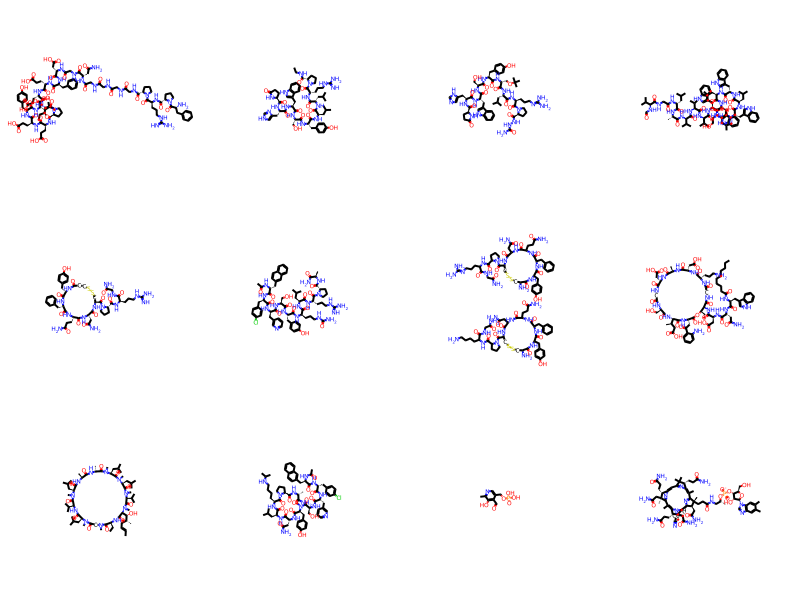

In [32]:
full2_df['SMILES'] = full2_df['SMILES'].astype(str).replace('nan', '')
sample_smiles = full2_df["SMILES"][0:12].values
sample_mols = [Chem.MolFromSmiles(smiles)for \
              smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,
                           molsPerRow = 4,
                           subImgSize = (200,200))
grid

In [53]:
import os.path as osp

import torch
from torch_geometric.data import Dataset, Data, download_url

# Assuming you have already obtained the unique atoms
unique_atoms = [
    'Ac', 'Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Bk', 'Br', 'C',
    'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'F', 'Fe', 'Ga', 'Gd',
    'Ge', 'H', 'He', 'Hf', 'Hg', 'Ho', 'I', 'In', 'K', 'Kr', 'La', 'Li',
    'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ne', 'Ni', 'O', 'Os',
    'P', 'Pb', 'Pd', 'Pt', 'Ra', 'Rb', 'Re', 'Ru', 'S', 'Sb', 'Se', 'Si',
    'Sm', 'Sn', 'Sr', 'Ta', 'Tc', 'Te', 'Ti', 'Tl', 'V', 'W', 'Xe', 'Y',
    'Zn', 'Zr'
]

# Mapping each unique atom to an integer
atom_to_index = {atom: index for index, atom in enumerate(unique_atoms)}

full2_df['SMILES'] = full2_df['SMILES'].astype(str).replace('nan', '')
class DopingDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None, pre_filter=None):
        self.test = test
        self.filename = filename
        super(DopingDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return self.filename
        #return ['data/raw/wada_filtered.csv', 'some_file_2', ...]
    
    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        #return ['data_1.pt', 'data_2.pt', ...]

    def download(self):
        pass
        # Download to `self.raw_dir`.
        #path = download_url(url, self.raw_dir)
        

#     def process(self):
#         idx = 0
#         for raw_path in self.raw_paths:
#             # Read data from `raw_path`.
#             data = Data(...)

#             if self.pre_filter is not None and not self.pre_filter(data):
#                 continue

#             if self.pre_transform is not None:
#                 data = self.pre_transform(data)

#             torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
#             idx += 1


    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        unique_atoms = set()  # Set to store unique atoms
        full2_df['SMILES'] = full2_df['SMILES'].astype(str).replace('nan', '')

        for index, mol in tqdm(full2_df.iterrows(), total=self.data.shape[0]):
            smiles = mol["SMILES"]
            if isinstance(smiles, str) and smiles.strip():  # Check if it's a non-empty string
                mol_obj = Chem.MolFromSmiles(smiles)
                
                if mol_obj is not None:
                    # Extract unique atoms from each molecule
                    unique_atoms.update([atom.GetSymbol() for atom in mol_obj.GetAtoms()])
                else:
                    print(f"Failed to parse SMILES: {smiles}")
        else:
            print(f"Ignoring invalid SMILES: {smiles}")
        atom_to_index = {atom: index for index, atom in enumerate(sorted(unique_atoms))}
        #TQDM = how far our process is
        for index, mol in tqdm(full2_df.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["SMILES"])
            if mol_obj is not None:
                node_labels = [atom_to_index[atom.GetSymbol()] for atom in mol_obj.GetAtoms()]
                # Get node features
                node_feats = self._get_node_features(mol_obj)
                # Get edge features
                edge_feats = self._get_edge_features(mol_obj)
                # Get adjacency info
                edge_index = self._get_adjacency_info(mol_obj)
                # Get labels info
                label = self._get_labels(mol["Doping"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["SMILES"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
                
        with open(osp.join(self.processed_dir, 'unique_atoms.txt'), 'w') as f:
            for atom in sorted(unique_atoms):
                f.write(atom + '\n')

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        if mol is not None:  # Check if mol is not None

            for atom in mol.GetAtoms():
                # Reconsider which features are relevant for my research
                node_feats = []
                # Feature 1: Atomic number        
                node_feats.append(atom.GetAtomicNum())
                # Feature 2: Atom degree
                # node_feats.append(atom.GetDegree())
                # # Feature 3: Formal charge
                # node_feats.append(atom.GetFormalCharge())
                # # Feature 4: Hybridization
                # node_feats.append(atom.GetHybridization())
                # # Feature 5: Aromaticity
                # node_feats.append(atom.GetIsAromatic())
                # # Feature 6: Total Num Hs
                # node_feats.append(atom.GetTotalNumHs())
                # # Feature 7: Radical Electrons
                # node_feats.append(atom.GetNumRadicalElectrons())
                # # Feature 8: In Ring
                # node_feats.append(atom.IsInRing())
                # # Feature 9: Chirality
                # node_feats.append(atom.GetChiralTag())

                atom_symbol = atom.GetSymbol()
                atom_index = self.atom_to_index[atom_symbol]
                node_feats.append(atom_index)

                # Append node features to matrix
                all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)


    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        if mol is not None:  # Check if mol is not None
            for bond in mol.GetBonds():
                edge_feats = []
                # Feature 1: Bond type (as double)
                edge_feats.append(bond.GetBondTypeAsDouble())
                # Feature 2: Rings
                edge_feats.append(bond.IsInRing())
                # Append edge features to matrix (twice, per direction)
                all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)


    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []  # Initialize edge_indices variable here

        if mol is not None:
            for bond in mol.GetBonds():
                i = bond.GetBeginAtomIdx()
                j = bond.GetEndAtomIdx()
                edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices


    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [50]:
dataset = DopingDataset(root = "full/", filename="full_data.csv")

In [51]:
# Open a text file in write mode
with open('full\\raw\\full_node_labels.txt', 'w') as f:
    # Assuming 'dataset' is your DopingDataset instance
    for i, sample in enumerate(dataset):
        node = sample.x.numpy()
        f.write(f"{node}\n")

# Print confirmation message
print("Node labels saved to 'WADA_node_labels.txt'")

KeyboardInterrupt: 